**下載套件**

In [1]:
!git clone https://github.com/joelgrus/data-science-from-scratch
!pip install d2l
!mv data-science-from-scratch/* .

Cloning into 'data-science-from-scratch'...
remote: Enumerating objects: 392, done.
remote: Total 392 (delta 0), reused 0 (delta 0), pack-reused 392
Receiving objects: 100% (392/392), 769.61 KiB | 7.06 MiB/s, done.
Resolving deltas: 100% (206/206), done.
     |████████████████████████████████| 81kB 6.2MB/s 


**單詞雲**

取出文章的關鍵字, 出現頻率愈高, 字體越大

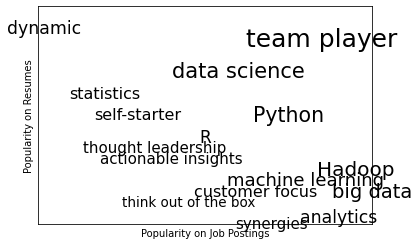

In [2]:
#單詞雲
import matplotlib.pyplot as plt
import random
plt.gca().clear()

data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

from matplotlib import pyplot as plt

def text_size(total: int) -> float:
    """equals 8 if total is 0, 28 if total is 200"""
    return 8 + total / 200 * 20

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word,
              ha='center', va='center',
              size=text_size(job_popularity + resume_popularity))
plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.show()

plt.close()

**N-gram語言模型**

In [3]:
from matplotlib import pyplot as plt

def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

content = soup.find("div", "main-post-radar-content")   # find article-body div
regex = r"[\w']+|[\.]"                       # matches a word or a period

document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

from collections import defaultdict

transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
    transitions[prev].append(current)

def generate_using_bigrams() -> str:
    current = "."   # this means the next word will start a sentence
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # choose one at random
        result.append(current)                         # append it to results
        if current == ".": return " ".join(result)     # if "." we're done

trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):

    if prev == ".":              # if the previous "word" was a period
        starts.append(current)   # then this is a start word

    trigram_transitions[(prev, current)].append(next)

def generate_using_trigrams() -> str:
    current = random.choice(starts)   # choose a random starting word
    prev = "."                        # and precede it with a '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)

        prev, current = current, next_word
        result.append(current)

        if current == ".":
            return " ".join(result)

In [4]:
#bi-gram
generate_using_bigrams()

'If youâ ve gotten some point traditional business .'

In [5]:
#3-gram
generate_using_trigrams()

'Hadoop processes data as a result .'

**文法**

In [6]:
from typing import List, Dict

# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V", "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

def is_terminal(token: str) -> bool:
    return token[0] != "_"

def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # If this is a terminal token, skip it.
        if is_terminal(token): continue

        # Otherwise, it's a non-terminal token,
        # so we need to choose a replacement at random.
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # Replacement could be e.g. "_NP _VP", so we need to
            # split it on spaces and splice it in.
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]

        # Now call expand on the new list of tokens.
        return expand(grammar, tokens)

    # If we get here we had all terminals and are done
    return tokens

def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

generate_sentence(grammar)

['linear',
 'big',
 'linear',
 'data science',
 'near',
 'logistic',
 'Python',
 'near',
 'linear',
 'Python',
 'about',
 'logistic',
 'regression',
 'tests']

**餘弦相似度**

判斷兩個單字的相似度

In [7]:
from scratch.linear_algebra import dot, Vector
from typing import Tuple
import random
import math

def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return dot(v1, v2) / math.sqrt(dot(v1, v1) * dot(v2, v2))

assert cosine_similarity([1., 1, 1], [2., 2, 2]) == 1, "same direction"
assert cosine_similarity([-1., -1], [2., 2]) == -1,    "opposite direction"
assert cosine_similarity([1., 0], [0., 1]) == 0,       "orthogonal"

colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

def make_sentence() -> str:
    return " ".join([
        "The",
        random.choice(colors),
        random.choice(nouns),
        random.choice(verbs),
        random.choice(adverbs),
        random.choice(adjectives),
        "."
    ])

NUM_SENTENCES = 50

random.seed(0)
sentences = [make_sentence() for _ in range(NUM_SENTENCES)]

**one-hot編碼**

In [8]:
from scratch.deep_learning import Tensor

class Vocabulary:
    def __init__(self, words: List[str] = None) -> None:
        self.w2i: Dict[str, int] = {}  # mapping word -> word_id
        self.i2w: Dict[int, str] = {}  # mapping word_id -> word

        for word in (words or []):     # If words were provided,
            self.add(word)             # add them.

    @property
    def size(self) -> int:
        """how many words are in the vocabulary"""
        return len(self.w2i)

    def add(self, word: str) -> None:
        if word not in self.w2i:        # If the word is new to us:
            word_id = len(self.w2i)     # Find the next id.
            self.w2i[word] = word_id    # Add to the word -> word_id map.
            self.i2w[word_id] = word    # Add to the word_id -> word map.

    def get_id(self, word: str) -> int:
        """return the id of the word (or None)"""
        return self.w2i.get(word)

    def get_word(self, word_id: int) -> str:
        """return the word with the given id (or None)"""
        return self.i2w.get(word_id)

    def one_hot_encode(self, word: str) -> Tensor:
        word_id = self.get_id(word)
        assert word_id is not None, f"unknown word {word}"

        return [1.0 if i == word_id else 0.0 for i in range(self.size)]

vocab = Vocabulary(["a", "b", "c"])
assert vocab.size == 3,              "there are 3 words in the vocab"
assert vocab.get_id("b") == 1,       "b should have word_id 1"
assert vocab.one_hot_encode("b") == [0, 1, 0]
assert vocab.get_id("z") is None,    "z is not in the vocab"
assert vocab.get_word(2) == "c",     "word_id 2 should be c"
vocab.add("z")
assert vocab.size == 4,              "now there are 4 words in the vocab"
assert vocab.get_id("z") == 3,       "now z should have id 3"
assert vocab.one_hot_encode("z") == [0, 0, 0, 1]

<Figure size 432x288 with 0 Axes>

**Embedding Layer**

以單字ID作為輸入，並送回一個詞向量

In [9]:
import json

def save_vocab(vocab: Vocabulary, filename: str) -> None:
    with open(filename, 'w') as f:
        json.dump(vocab.w2i, f)       # Only need to save w2i

def load_vocab(filename: str) -> Vocabulary:
    vocab = Vocabulary()
    with open(filename) as f:
        # Load w2i and generate i2w from it.
        vocab.w2i = json.load(f)
        vocab.i2w = {id: word for word, id in vocab.w2i.items()}
    return vocab

from typing import Iterable
from scratch.deep_learning import Layer, Tensor, random_tensor, zeros_like

class Embedding(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        # One vector of size embedding_dim for each desired embedding
        self.embeddings = random_tensor(num_embeddings, embedding_dim)
        self.grad = zeros_like(self.embeddings)

        # Save last input id
        self.last_input_id = None

    def forward(self, input_id: int) -> Tensor:
        """Just select the embedding vector corresponding to the input id"""
        self.input_id = input_id    # remember for use in backpropagation

        return self.embeddings[input_id]

    def backward(self, gradient: Tensor) -> None:
        # Zero out the gradient corresponding to the last input.
        # This is way cheaper than creating a new all-zero tensor each time.
        if self.last_input_id is not None:
            zero_row = [0 for _ in range(self.embedding_dim)]
            self.grad[self.last_input_id] = zero_row

        self.last_input_id = self.input_id
        self.grad[self.input_id] = gradient

    def params(self) -> Iterable[Tensor]:
        return [self.embeddings]

    def grads(self) -> Iterable[Tensor]:
        return [self.grad]

class TextEmbedding(Embedding):
    def __init__(self, vocab: Vocabulary, embedding_dim: int) -> None:
        # Call the superclass constructor
        super().__init__(vocab.size, embedding_dim)

        # And hang onto the vocab
        self.vocab = vocab

    def __getitem__(self, word: str) -> Tensor:
        word_id = self.vocab.get_id(word)
        if word_id is not None:
            return self.embeddings[word_id]
        else:
            return None

    def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
        """Returns the n closest words based on cosine similarity"""
        vector = self[word]

        # Compute pairs (similarity, other_word), and sort most similar first
        scores = [(cosine_similarity(vector, self.embeddings[i]), other_word)
                  for other_word, i in self.vocab.w2i.items()]
        scores.sort(reverse=True)

        return scores[:n]

import re

# This is not a great regex, but it works on our data.
tokenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower())
                        for sentence in sentences]

# Create a vocabulary (that is, a mapping word -> word_id) based on our text.
vocab = Vocabulary(word
                    for sentence_words in tokenized_sentences
                    for word in sentence_words)

from scratch.deep_learning import Tensor, one_hot_encode

inputs: List[int] = []
targets: List[Tensor] = []

for sentence in tokenized_sentences:
    for i, word in enumerate(sentence):          # For each word
        for j in [i - 2, i - 1, i + 1, i + 2]:   # take the nearby locations
            if 0 <= j < len(sentence):           # that aren't out of bounds
                nearby_word = sentence[j]        # and get those words.

                # Add an input that's the original word_id
                inputs.append(vocab.get_id(word))

                # Add a target that's the one-hot-encoded nearby word
                targets.append(vocab.one_hot_encode(nearby_word))


# Model for learning word vectors

from scratch.deep_learning import Sequential, Linear

random.seed(0)
EMBEDDING_DIM = 5  # seems like a good size

# Define the embedding layer separately, so we can reference it.
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM)

model = Sequential([
    # Given a word (as a vector of word_ids), look up its embedding.
    embedding,
    # And use a linear layer to compute scores for "nearby words".
    Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size)
])


# Train the word vector model

from scratch.deep_learning import SoftmaxCrossEntropy, Momentum, GradientDescent

loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate=0.01)

for epoch in range(100):
    epoch_loss = 0.0
    for input, target in zip(inputs, targets):
        predicted = model.forward(input)
        epoch_loss += loss.loss(predicted, target)
        gradient = loss.gradient(predicted, target)
        model.backward(gradient)
        optimizer.step(model)
    print(epoch, epoch_loss)            # Print the loss
    print(embedding.closest("black"))   # and also a few nearest words
    print(embedding.closest("slow"))    # so we can see what's being
    print(embedding.closest("car"))     # learned.

# Plot word vectors
plt.close()

0 2970.156429387063
[(1.0, 'black'), (0.7927247753692507, 'blue'), (0.5911733314896048, 'cat'), (0.5716654981660781, 'the'), (0.3026892975059721, 'car')]
[(1.0, 'slow'), (0.8936272640937163, 'green'), (0.5272141409772461, '.'), (0.356013304388346, 'yellow'), (0.29982973123116025, 'blue')]
[(1.0, 'car'), (0.7030889033452818, 'cat'), (0.519105254858335, 'fast'), (0.4236692673437953, 'very'), (0.3848186865089063, 'quite')]
1 2865.855510833289
[(1.0, 'black'), (0.8076054877794636, 'blue'), (0.6112459000264461, 'cat'), (0.5676562111596322, 'the'), (0.3273307461476133, 'car')]
[(1.0, 'slow'), (0.8795208130766505, 'green'), (0.5675261127213351, '.'), (0.3624106663078739, 'yellow'), (0.3593451263736934, 'boat')]
[(1.0, 'car'), (0.7121322616680856, 'cat'), (0.49717481866583696, 'fast'), (0.4099921723101964, 'very'), (0.3655326707405854, 'quite')]
2 2815.035526656466
[(1.0, 'black'), (0.8240340241906855, 'blue'), (0.6310891601317347, 'cat'), (0.5448895203899405, 'the'), (0.3541498544488745, 'car

模型訓練完之後, 探索一下最相似的字詞

In [10]:
# Explore most similar words

pairs = [(cosine_similarity(embedding[w1], embedding[w2]), w1, w2)
          for w1 in vocab.w2i
          for w2 in vocab.w2i
          if w1 < w2]
pairs.sort(reverse=True)
print(pairs[:5])

[(0.9948304450324577, 'bed', 'cat'), (0.9920899253848235, 'seems', 'was'), (0.9883988811665566, 'bed', 'boat'), (0.9821293900663808, 'black', 'blue'), (0.9709525703302305, 'green', 'red')]


提取出前兩個主成份(principal components), 然後繪製

dv: 43.206: 100%|██████████| 100/100 [00:00<00:00, 259.85it/s]


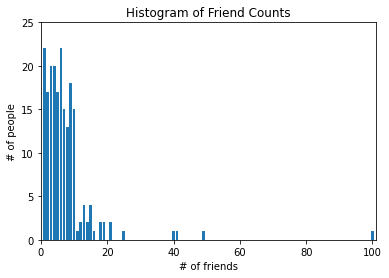

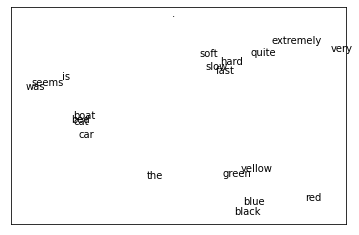

In [11]:
from scratch.working_with_data import pca, transform
import matplotlib.pyplot as plt

# Extract the first two principal components and transform the word vectors
components = pca(embedding.embeddings, 2)
transformed = transform(embedding.embeddings, components)

# Scatter the points (and make them white so they're "invisible")
fig, ax = plt.subplots()
ax.scatter(*zip(*transformed), marker='.', color='w')

# Add annotations for each word at its transformed location
for word, idx in vocab.w2i.items():
    ax.annotate(word, transformed[idx])

# And hide the axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

plt.savefig('im/word_vectors')
plt.gca().clear()
plt.close()

**RNN遞迴神經網路**

output[o] = dot(w[o], input) + b[o]

使用兩組權重：

一組用於輸入，一組用於輸出

output[o] = dot(w[o], input) + dot(u[o], hidden) + b[o]

In [12]:
from scratch.deep_learning import tensor_apply, tanh

class SimpleRnn(Layer):
    """Just about the simplest possible recurrent layer."""
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.w = random_tensor(hidden_dim, input_dim, init='xavier')
        self.u = random_tensor(hidden_dim, hidden_dim, init='xavier')
        self.b = random_tensor(hidden_dim)

        self.reset_hidden_state()

    def reset_hidden_state(self) -> None:
        self.hidden = [0 for _ in range(self.hidden_dim)]

    def forward(self, input: Tensor) -> Tensor:
        self.input = input              # Save both input and previous
        self.prev_hidden = self.hidden  # hidden state to use in backprop.

        a = [(dot(self.w[h], input) +           # weights @ input
              dot(self.u[h], self.hidden) +     # weights @ hidden
              self.b[h])                        # bias
             for h in range(self.hidden_dim)]

        self.hidden = tensor_apply(tanh, a)  # Apply tanh activation
        return self.hidden                   # and return the result.

    def backward(self, gradient: Tensor):
        # Backpropagate through the tanh
        a_grad = [gradient[h] * (1 - self.hidden[h] ** 2)
                  for h in range(self.hidden_dim)]

        # b has the same gradient as a
        self.b_grad = a_grad

        # Each w[h][i] is multiplied by input[i] and added to a[h],
        # so each w_grad[h][i] = a_grad[h] * input[i]
        self.w_grad = [[a_grad[h] * self.input[i]
                        for i in range(self.input_dim)]
                       for h in range(self.hidden_dim)]

        # Each u[h][h2] is multiplied by hidden[h2] and added to a[h],
        # so each u_grad[h][h2] = a_grad[h] * prev_hidden[h2]
        self.u_grad = [[a_grad[h] * self.prev_hidden[h2]
                        for h2 in range(self.hidden_dim)]
                       for h in range(self.hidden_dim)]

        # Each input[i] is multiplied by every w[h][i] and added to a[h],
        # so each input_grad[i] = sum(a_grad[h] * w[h][i] for h in ...)
        return [sum(a_grad[h] * self.w[h][i] for h in range(self.hidden_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.u, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.u_grad, self.b_grad]

In [13]:
from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1, 2, 3, 4, 5, 6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

def random_y_given_x(x: int) -> int:
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

def random_x_given_y(y: int) -> int:
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

def sample_from(weights: List[float]) -> int:
    """returns i with probability weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random()      # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                       # return the smallest i such that
        if rnd <= 0: return i          # weights[0] + ... + weights[i] >= rnd

**字元級RNN**

In [14]:
from bs4 import BeautifulSoup
import tqdm
import requests

url = "https://www.ycombinator.com/topcompanies/"
soup = BeautifulSoup(requests.get(url).text, 'html5lib')

# We get the companies twice, so use a set comprehension to deduplicate.
companies = list({b.text
                  for b in soup("b")
                  if "h4" in b.get("class", ())})
companies = ["Airbnb","DoorDash","Stripe","Cruise","Instacart","Dropbox","Coinbase","Zapier","Ginkgo Bioworks","Rappi","Gusto","Scale AI","PagerDuty","Flexport","Segment","Reddit","MessageBird","Brex","Gitlab","Faire","Relativity Space","Amplitude","Checkr","Meesho","GOAT Group","Podium","Rippling","Helion Energy","Fivetran","Momentus","Webflow","Boom","Razorpay","Twitch","Weave","Retool","Iconlad","GoCardless","PlanGrid","Mixpanel","Benchling","Front","Goldbelly","Snapdocs","Modern Health","ShipBob","MBX","Standard Cognition","Embark Trucks","The Athletics","SendBird","Lattice","Turepill","Scribd","Atomwise","Rescale","EquipmentShare","Newfront Insurance","GrubMarket","InfluxData","People.ai","Xendit","Ridecell","Shipper","MatterPort","Sift","Duffel","Vouch","Algolia","Mux","Presto","NURX","EasyPost","Outschool","Mattermost","Observe.AI ","Modern Treasury","Nova Creadit","Proxy","Flock Safety","OkCredit","UpKeep","Optimizely","Heap","SingleStore","WePay","Khartabook","Weebly","Geoko Robotics","Fivestars","Squire Technology","CoreOS","Lambda School","PAYFAZZ","ClearTax","Clever","Volansi","Heroku","Solugen","Canbly","H1"]
#assert len(companies) == 101

vocab = Vocabulary([c for company in companies for c in company])

START = "^"
STOP = "$"

# We need to add them to the vocabulary too.
vocab.add(START)
vocab.add(STOP)

HIDDEN_DIM = 32  # You should experiment with different sizes!

rnn1 =  SimpleRnn(input_dim=vocab.size, hidden_dim=HIDDEN_DIM)
rnn2 =  SimpleRnn(input_dim=HIDDEN_DIM, hidden_dim=HIDDEN_DIM)
linear = Linear(input_dim=HIDDEN_DIM, output_dim=vocab.size)

model = Sequential([
    rnn1,
    rnn2,
    linear
])

from scratch.deep_learning import softmax

def generate(seed: str = START, max_len: int = 50) -> str:
    rnn1.reset_hidden_state()  # Reset both hidden states.
    rnn2.reset_hidden_state()
    output = [seed]            # Start the output with the specified seed.

    # Keep going until we produce the STOP character or reach the max length
    while output[-1] != STOP and len(output) < max_len:
        # Use the last character as the input
        input = vocab.one_hot_encode(output[-1])

        # Generate scores using the model
        predicted = model.forward(input)

        # Convert them to probabilities and draw a random char_id
        probabilities = softmax(predicted)
        next_char_id = sample_from(probabilities)

        # Add the corresponding char to our output
        output.append(vocab.get_word(next_char_id))

    # Get rid of START and END characters and return the word.
    return ''.join(output[1:-1])

loss = SoftmaxCrossEntropy()
optimizer = Momentum(learning_rate=0.01, momentum=0.9)

for epoch in range(300):
    random.shuffle(companies)  # Train in a different order each epoch.
    epoch_loss = 0             # Track the loss.
    for company in tqdm.tqdm(companies):
        rnn1.reset_hidden_state()  # Reset both hidden states.
        rnn2.reset_hidden_state()
        company = START + company + STOP   # Add START and STOP characters.

        # The rest is just our usual training loop, except that the inputs
        # and target are the one-hot-encoded previous and next characters.
        for prev, next in zip(company, company[1:]):
            input = vocab.one_hot_encode(prev)
            target = vocab.one_hot_encode(next)
            predicted = model.forward(input)
            epoch_loss += loss.loss(predicted, target)
            gradient = loss.gradient(predicted, target)
            model.backward(gradient)
            optimizer.step(model)

    # Each epoch print the loss and also generate a name
    print(epoch, epoch_loss, generate())

    # Turn down the learning rate for the last 100 epochs.
    # There's no principled reason for this, but it seems to work.
    if epoch == 200:
        optimizer.lr *= 0.1

  2%|▏         | 2/101 [00:00<00:06, 14.26it/s]

0 3279.899780326598 


  2%|▏         | 2/101 [00:00<00:05, 19.23it/s]

1 3162.138119417686 


  2%|▏         | 2/101 [00:00<00:07, 13.95it/s]

2 3089.1031434116626 MwZuoro


  2%|▏         | 2/101 [00:00<00:08, 12.27it/s]

3 3036.201577403706 StYy u


  2%|▏         | 2/101 [00:00<00:09, 10.89it/s]

4 2993.2260015128413 Inedlcdrey li1eiYdlzbnlpTlBo


  2%|▏         | 2/101 [00:00<00:08, 12.18it/s]

5 2959.081115922407 RoyT


  2%|▏         | 2/101 [00:00<00:06, 15.77it/s]

6 2942.734635368407 Ptemarvdatauc


  1%|          | 1/101 [00:00<00:10,  9.96it/s]

7 2921.1585963023826 Gileph


  1%|          | 1/101 [00:00<00:10,  9.58it/s]

8 2903.776733920746 HaqlFtb


  2%|▏         | 2/101 [00:00<00:05, 18.58it/s]

9 2897.050697579374 Setahbyno


  2%|▏         | 2/101 [00:00<00:06, 15.70it/s]

10 2882.6372161049358 Sakpamuie1toCcalu


  3%|▎         | 3/101 [00:00<00:04, 20.02it/s]

11 2867.1754164881327 Reryrk


  3%|▎         | 3/101 [00:00<00:05, 18.58it/s]

12 2852.7760717115743 RetpKktor 


  3%|▎         | 3/101 [00:00<00:04, 20.84it/s]

13 2836.299672328354 Orereaost


  2%|▏         | 2/101 [00:00<00:05, 17.56it/s]

14 2829.9020542090816 Zewmomon hy


  2%|▏         | 2/101 [00:00<00:06, 16.03it/s]

15 2809.1818978553065 Wlnckx


  1%|          | 1/101 [00:00<00:13,  7.57it/s]

16 2800.7823267443196 Sesqdas


  2%|▏         | 2/101 [00:00<00:05, 17.95it/s]

17 2783.374011925232 SlilrahSrbow


  1%|          | 1/101 [00:00<00:10,  9.26it/s]

18 2775.571180932636 HotikntkSt


  2%|▏         | 2/101 [00:00<00:06, 14.70it/s]

19 2766.817077428918 Gamame


  2%|▏         | 2/101 [00:00<00:04, 19.95it/s]

20 2746.155490020534 .edpdahu


  2%|▏         | 2/101 [00:00<00:05, 18.18it/s]

21 2737.3311611786703 Tpserreikh


  2%|▏         | 2/101 [00:00<00:08, 11.65it/s]

22 2717.1593351630554 Welnsie


  2%|▏         | 2/101 [00:00<00:08, 11.22it/s]

23 2699.601853625467 Apmepgesi


  2%|▏         | 2/101 [00:00<00:05, 19.39it/s]

24 2694.6641652392304 Mhoklal


  3%|▎         | 3/101 [00:00<00:04, 20.49it/s]

25 2689.0534107842996 Delrdti


  1%|          | 1/101 [00:00<00:10,  9.17it/s]

26 2681.070204481806 Suai


  3%|▎         | 3/101 [00:00<00:05, 16.71it/s]

27 2661.012795413836 GoxbF


  2%|▏         | 2/101 [00:00<00:07, 13.31it/s]

28 2645.8696916887793 Scrhil


  2%|▏         | 2/101 [00:00<00:06, 15.03it/s]

29 2642.76908767524 Mfunl


  2%|▏         | 2/101 [00:00<00:06, 14.61it/s]

30 2626.603138316034 Prcoselala


  2%|▏         | 2/101 [00:00<00:05, 19.76it/s]

31 2625.9945425082487 Tlep


  2%|▏         | 2/101 [00:00<00:07, 13.11it/s]

32 2620.102809157612 Wtibm


  2%|▏         | 2/101 [00:00<00:05, 18.65it/s]

33 2606.426051166319 Droc


  2%|▏         | 2/101 [00:00<00:07, 13.46it/s]

34 2599.5173184773244 reopb Toer


  2%|▏         | 2/101 [00:00<00:05, 16.52it/s]

35 2589.416760849299 MfgbHama


  2%|▏         | 2/101 [00:00<00:05, 17.61it/s]

36 2574.408220715843 Kinpiy


  1%|          | 1/101 [00:00<00:10,  9.96it/s]

37 2565.7409105527613 Fqhkpo


  2%|▏         | 2/101 [00:00<00:07, 13.74it/s]

38 2557.636704965638 GlacBertarilas


  2%|▏         | 2/101 [00:00<00:06, 15.32it/s]

39 2550.445225763152 Iiupcargocc


  2%|▏         | 2/101 [00:00<00:09, 10.86it/s]

40 2543.139990517558 Beplarrc


  2%|▏         | 2/101 [00:00<00:09, 10.26it/s]

41 2530.7468301784984 Melanr


  2%|▏         | 2/101 [00:00<00:05, 18.33it/s]

42 2518.3434613795666 Meuxt


  2%|▏         | 2/101 [00:00<00:07, 13.70it/s]

43 2515.8654854507513 Zkwytyg


  2%|▏         | 2/101 [00:00<00:04, 19.80it/s]

44 2505.8576977367443 Scolichh


  1%|          | 1/101 [00:00<00:10,  9.88it/s]

45 2498.0779018254375 Megkry Tuos


  2%|▏         | 2/101 [00:00<00:07, 13.03it/s]

46 2493.4875842252695 Gofdartal


  2%|▏         | 2/101 [00:00<00:07, 12.60it/s]

47 2478.0016724349466 Apset


  2%|▏         | 2/101 [00:00<00:05, 18.85it/s]

48 2471.5057591234595 SteiD


  2%|▏         | 2/101 [00:00<00:06, 15.87it/s]

49 2462.8087063124376 Ulibeal


  2%|▏         | 2/101 [00:00<00:06, 14.64it/s]

50 2446.6395983119946 BeCrXti


  2%|▏         | 2/101 [00:00<00:05, 18.35it/s]

51 2444.431949451213 Claiciloiasoap


  2%|▏         | 2/101 [00:00<00:07, 13.37it/s]

52 2420.540838568361 Wepmeol


  2%|▏         | 2/101 [00:00<00:05, 17.18it/s]

53 2402.2367620947857 GPutl


  2%|▏         | 2/101 [00:00<00:06, 14.97it/s]

54 2412.754298099943 Seslaty


  1%|          | 1/101 [00:00<00:10,  9.68it/s]

55 2389.546487509789 Piamab


  2%|▏         | 2/101 [00:00<00:08, 12.08it/s]

56 2379.7964370960685 Meiwe Cion


  2%|▏         | 2/101 [00:00<00:06, 15.82it/s]

57 2367.812596871286 Mmipkly


  2%|▏         | 2/101 [00:00<00:05, 17.03it/s]

58 2357.123539756886 FlalaS


  2%|▏         | 2/101 [00:00<00:07, 13.82it/s]

59 2349.3945335456083 GefsatoOT


  2%|▏         | 2/101 [00:00<00:06, 14.85it/s]

60 2323.899057928422 Mhob


  2%|▏         | 2/101 [00:00<00:04, 19.97it/s]

61 2319.213216351814 Scanl


  3%|▎         | 3/101 [00:00<00:06, 15.45it/s]

62 2300.529106379983 Snecka


  2%|▏         | 2/101 [00:00<00:05, 17.10it/s]

63 2294.014312553888 Comkre.


  2%|▏         | 2/101 [00:00<00:08, 11.77it/s]

64 2274.405952292475 Eebsoroaysh


  2%|▏         | 2/101 [00:00<00:06, 16.13it/s]

65 2270.340910611859 Hoqdrmbost


  2%|▏         | 2/101 [00:00<00:05, 17.43it/s]

66 2262.3560240471197 Ebuapderag


  2%|▏         | 2/101 [00:00<00:06, 15.69it/s]

67 2230.9822737499476 OZdestis


  2%|▏         | 2/101 [00:00<00:09, 10.72it/s]

68 2219.6927900269143 Cuferel


  2%|▏         | 2/101 [00:00<00:06, 14.78it/s]

69 2217.9257530583423 Fcuch


  2%|▏         | 2/101 [00:00<00:05, 19.03it/s]

70 2199.135134019431 Ela Trexsozeebirgt


  2%|▏         | 2/101 [00:00<00:04, 19.99it/s]

71 2193.573475774223 Mafsait


  2%|▏         | 2/101 [00:00<00:07, 13.78it/s]

72 2182.5970691973594 Sinb


  3%|▎         | 3/101 [00:00<00:05, 18.88it/s]

73 2167.2501364374643 UmPfitirDtere


  0%|          | 0/101 [00:00<?, ?it/s]

74 2138.1144893259507 AuOve


  1%|          | 1/101 [00:00<00:10,  9.31it/s]

75 2120.399304905821 Kcalkoul


  2%|▏         | 2/101 [00:00<00:05, 17.75it/s]

76 2115.6718778289933 Sortab Itlerole


  2%|▏         | 2/101 [00:00<00:08, 12.00it/s]

77 2091.330675505871 Heoidh


  2%|▏         | 2/101 [00:00<00:08, 11.50it/s]

78 2075.7910691489524 Bawirtersort


  2%|▏         | 2/101 [00:00<00:05, 17.31it/s]

79 2080.3576646650067 CoCrbmloturod


  2%|▏         | 2/101 [00:00<00:05, 17.67it/s]

80 2054.8700411392556 OupXlan


  2%|▏         | 2/101 [00:00<00:05, 18.21it/s]

81 2028.9084112213648 Gadtrfn


  2%|▏         | 2/101 [00:00<00:05, 17.59it/s]

82 2014.6977043553895 UnKfrinn


  2%|▏         | 2/101 [00:00<00:07, 13.67it/s]

83 2012.4461920748247 Teondl


  2%|▏         | 2/101 [00:00<00:07, 14.09it/s]

84 1982.1911892895203 GmfdKl


  2%|▏         | 2/101 [00:00<00:06, 14.63it/s]

85 1977.4686200925426 Pise


  2%|▏         | 2/101 [00:00<00:07, 13.53it/s]

86 1945.393751578874 Fruces


  2%|▏         | 2/101 [00:00<00:06, 16.01it/s]

87 1938.6976224010862 Godbr


  2%|▏         | 2/101 [00:00<00:05, 17.88it/s]

88 1917.9373797743901 InpdibU Roisk


  2%|▏         | 2/101 [00:00<00:06, 15.33it/s]

89 1936.5804555984337 Croxy


  2%|▏         | 2/101 [00:00<00:05, 16.53it/s]

90 1906.3472162517246 Thabl .r


  2%|▏         | 2/101 [00:00<00:07, 13.66it/s]

91 1891.4843456135775 Five


  2%|▏         | 2/101 [00:00<00:06, 16.29it/s]

92 1896.8177320409707 Waven


  2%|▏         | 2/101 [00:00<00:05, 18.71it/s]

93 1870.7445202321405 Welmiphh


  1%|          | 1/101 [00:00<00:10,  9.91it/s]

94 1853.5598895222931 IleyBottigud


  2%|▏         | 2/101 [00:00<00:06, 15.76it/s]

95 1861.8094841316947 Eattard


  2%|▏         | 2/101 [00:00<00:05, 18.27it/s]

96 1862.646205601671 Lify


  2%|▏         | 2/101 [00:00<00:06, 15.81it/s]

97 1829.0672614789405 Reave


  2%|▏         | 2/101 [00:00<00:05, 16.69it/s]

98 1832.2702026434888 Uateel


  2%|▏         | 2/101 [00:00<00:07, 13.39it/s]

99 1810.3562779436772 B1uikm


  2%|▏         | 2/101 [00:00<00:06, 16.38it/s]

100 1790.7839939869739 MonkOS


  2%|▏         | 2/101 [00:00<00:06, 16.11it/s]

101 1817.6408674360096 Sharel


  2%|▏         | 2/101 [00:00<00:06, 16.27it/s]

102 1765.5591952532927 Draxdn


  1%|          | 1/101 [00:00<00:12,  7.84it/s]

103 1737.0221380982434 Cat


  2%|▏         | 2/101 [00:00<00:06, 14.62it/s]

104 1740.549699234304 Pooirelioipk Toge


  2%|▏         | 2/101 [00:00<00:05, 18.23it/s]

105 1727.4488313412694 Repdorit


  2%|▏         | 2/101 [00:00<00:06, 16.33it/s]

106 1705.5518021534747 DoX


  2%|▏         | 2/101 [00:00<00:07, 12.49it/s]

107 1725.025447504115 Redpal


  1%|          | 1/101 [00:00<00:13,  7.25it/s]

108 1693.708760441237 MoorP


  2%|▏         | 2/101 [00:00<00:07, 13.49it/s]

109 1637.6772600384352 FlexMore


  1%|          | 1/101 [00:00<00:12,  7.93it/s]

110 1666.747739180218 Rebflivp Se


  2%|▏         | 2/101 [00:00<00:06, 14.77it/s]

111 1668.9459859670478 Sendrt


  1%|          | 1/101 [00:00<00:11,  8.77it/s]

112 1625.8844500659654 Sito Suirt


  1%|          | 1/101 [00:00<00:12,  7.86it/s]

113 1630.2081880310814 Cherdare


  2%|▏         | 2/101 [00:00<00:08, 12.17it/s]

114 1626.4432196454925 Stgcence Sgh


  1%|          | 1/101 [00:00<00:12,  7.88it/s]

115 1633.4369013307455 Paoplestare


  2%|▏         | 2/101 [00:00<00:06, 16.48it/s]

116 1625.7513407394742 Weacel


  2%|▏         | 2/101 [00:00<00:05, 19.04it/s]

117 1560.6551515658293 Libgh


  2%|▏         | 2/101 [00:00<00:06, 15.33it/s]

118 1602.439153841313 TwrX


  1%|          | 1/101 [00:00<00:12,  8.17it/s]

119 1561.9148350672474 Bow1ey


  2%|▏         | 2/101 [00:00<00:07, 14.08it/s]

120 1545.9395959008707 SqapBoest


  2%|▏         | 2/101 [00:00<00:07, 13.58it/s]

121 1550.7960585093747 Eatsinel


  3%|▎         | 3/101 [00:00<00:05, 19.05it/s]

122 1574.5968535882255 Groqt


  2%|▏         | 2/101 [00:00<00:05, 17.11it/s]

123 1536.2539700836348 ItexMo 


  2%|▏         | 2/101 [00:00<00:06, 15.71it/s]

124 1541.106656501905 Nhapdogt


  2%|▏         | 2/101 [00:00<00:06, 14.25it/s]

125 1584.235715474235 L1apduss


  2%|▏         | 2/101 [00:00<00:06, 14.77it/s]

126 1541.9815728812848 Modern HegoniClhBel


  2%|▏         | 2/101 [00:00<00:06, 15.49it/s]

127 1482.9970570346243 Helcan


  2%|▏         | 2/101 [00:00<00:08, 12.36it/s]

128 1496.1265096005286 Xeerdost


  2%|▏         | 2/101 [00:00<00:05, 18.03it/s]

129 1501.5226850338825 Enrapd


  2%|▏         | 2/101 [00:00<00:05, 19.56it/s]

130 1446.723217217765 PBeop


  2%|▏         | 2/101 [00:00<00:06, 14.18it/s]

131 1419.5749141553915 Messane


  2%|▏         | 2/101 [00:00<00:06, 14.99it/s]

132 1471.2880768401828 MaRerfre


  2%|▏         | 2/101 [00:00<00:05, 18.88it/s]

133 1459.9046599120727 Relach


  1%|          | 1/101 [00:00<00:15,  6.43it/s]

134 1488.228316805269 MermleASes


  3%|▎         | 3/101 [00:00<00:03, 25.27it/s]

135 1480.047406751775 Postate


  2%|▏         | 2/101 [00:00<00:07, 12.65it/s]

136 1449.8264912268132 GroCol


  2%|▏         | 2/101 [00:00<00:05, 16.96it/s]

137 1516.9433117745061 Poorout


  3%|▎         | 3/101 [00:00<00:04, 21.15it/s]

138 1481.3136267141938 Enbab


  2%|▏         | 2/101 [00:00<00:07, 13.30it/s]

139 1444.9702087006592 Matlrea


  2%|▏         | 2/101 [00:00<00:09, 10.63it/s]

140 1405.9164469760567 Sin


  1%|          | 1/101 [00:00<00:10,  9.11it/s]

141 1399.1181048955991 GetarkS


  3%|▎         | 3/101 [00:00<00:05, 18.82it/s]

142 1427.7631184127429 Helodisely


  2%|▏         | 2/101 [00:00<00:06, 15.40it/s]

143 1389.6387418593692 Xenaly


  2%|▏         | 2/101 [00:00<00:07, 12.78it/s]

144 1402.4903555741046 Mub


  1%|          | 1/101 [00:00<00:10,  9.72it/s]

145 1381.208395183276 Infnhipp


  2%|▏         | 2/101 [00:00<00:05, 18.33it/s]

146 1363.7896958736067 HeroOC


  2%|▏         | 2/101 [00:00<00:05, 18.21it/s]

147 1400.0106636612709 Proited


  3%|▎         | 3/101 [00:00<00:05, 18.61it/s]

148 1399.7672834531227 Weer


  2%|▏         | 2/101 [00:00<00:05, 19.22it/s]

149 1325.3102039181038 DoorABike Siryli


  1%|          | 1/101 [00:00<00:11,  8.48it/s]

150 1318.755683232816 ClenGo Rchiol


  2%|▏         | 2/101 [00:00<00:09, 10.64it/s]

151 1330.4229632274141 Rollackd


  1%|          | 1/101 [00:00<00:11,  8.63it/s]

152 1311.6377332731377 Relarns


  1%|          | 1/101 [00:00<00:11,  9.01it/s]

153 1315.6864213322951 Vrea


  2%|▏         | 2/101 [00:00<00:06, 14.70it/s]

154 1278.5734657327168 Shrtnollch


  2%|▏         | 2/101 [00:00<00:06, 14.43it/s]

155 1328.1653278254632 Stgenthe


  2%|▏         | 2/101 [00:00<00:08, 11.47it/s]

156 1276.5890973472174 Tqoxy


  2%|▏         | 2/101 [00:00<00:05, 18.90it/s]

157 1278.7111437543122 Reefly


  2%|▏         | 2/101 [00:00<00:07, 13.51it/s]

158 1319.8739555084844 Inonelity


  3%|▎         | 3/101 [00:00<00:04, 20.30it/s]

159 1291.2389100427768 Pro Atoderard 


  2%|▏         | 2/101 [00:00<00:07, 13.82it/s]

160 1371.5652491229628 CoipAGre


  2%|▏         | 2/101 [00:00<00:06, 14.57it/s]

161 1286.2922912601084 InfapDoGy


  2%|▏         | 2/101 [00:00<00:05, 16.77it/s]

162 1304.798865232819 Nerikw


  2%|▏         | 2/101 [00:00<00:06, 14.85it/s]

163 1265.317176192394 Cogitins


  1%|          | 1/101 [00:00<00:10,  9.46it/s]

164 1334.5463290733921 Mamizel


  3%|▎         | 3/101 [00:00<00:04, 20.24it/s]

165 1331.1780359659447 Shappard Herxth


  2%|▏         | 2/101 [00:00<00:06, 16.28it/s]

166 1307.8017537045441 SUarto


  2%|▏         | 2/101 [00:00<00:05, 18.46it/s]

167 1272.8898864960993 NewfonA


  1%|          | 1/101 [00:00<00:14,  6.73it/s]

168 1292.615438887759 Reap


  2%|▏         | 2/101 [00:00<00:06, 14.34it/s]

169 1374.50747222763 I GrboserDu


  2%|▏         | 2/101 [00:00<00:06, 14.47it/s]

170 1229.5778854683197 Givlid


  2%|▏         | 2/101 [00:00<00:04, 19.84it/s]

171 1296.4859428388297 Omprelituin


  2%|▏         | 2/101 [00:00<00:05, 16.63it/s]

172 1259.2360475070486 Rhestre


  2%|▏         | 2/101 [00:00<00:05, 18.22it/s]

173 1267.255858739594 Rewfro Cred


  2%|▏         | 2/101 [00:00<00:07, 13.53it/s]

174 1337.3177218508415 ClexAGnZark T 


  2%|▏         | 2/101 [00:00<00:05, 16.86it/s]

175 1400.6785127856824 Theckrit


  2%|▏         | 2/101 [00:00<00:06, 15.96it/s]

176 1229.4197596634788 Sipelt Z


  2%|▏         | 2/101 [00:00<00:05, 17.75it/s]

177 1313.5677014999608 Pruion IDonlad


  2%|▏         | 2/101 [00:00<00:09, 10.45it/s]

178 1342.3586509250413 MixDe


  2%|▏         | 2/101 [00:00<00:06, 15.66it/s]

179 1246.6729989911792 SUxpGub


  3%|▎         | 3/101 [00:00<00:03, 24.79it/s]

180 1267.4941083231815 Ampluce


  2%|▏         | 2/101 [00:00<00:05, 18.88it/s]

181 1248.21525824514 Metork RouceooI


  3%|▎         | 3/101 [00:00<00:05, 17.85it/s]

182 1266.827717543841 GiCridp CoeanK Ia Treamb


  2%|▏         | 2/101 [00:00<00:08, 11.02it/s]

183 1322.9288637069337 Zafta


  2%|▏         | 2/101 [00:00<00:07, 13.71it/s]

184 1341.442678305678 RelarDontort


  2%|▏         | 2/101 [00:00<00:08, 11.18it/s]

185 1301.478174814512 Goukuion Enoly


  2%|▏         | 2/101 [00:00<00:05, 18.30it/s]

186 1258.1660985293324 Uqferare


  2%|▏         | 2/101 [00:00<00:06, 14.55it/s]

187 1288.165155396793 SqKie Rch


  3%|▎         | 3/101 [00:00<00:04, 20.37it/s]

188 1259.9642175841236 Mappditl


  2%|▏         | 2/101 [00:00<00:04, 19.85it/s]

189 1272.8471960955387 ShgokBarDy


  2%|▏         | 2/101 [00:00<00:06, 15.48it/s]

190 1280.2596298606538 ShuiMel


  3%|▎         | 3/101 [00:00<00:04, 20.56it/s]

191 1236.9166696090888 Seadhirit


  2%|▏         | 2/101 [00:00<00:06, 14.34it/s]

192 1128.5523628343146 Outschorruy


  1%|          | 1/101 [00:00<00:12,  7.94it/s]

193 1165.6216988370973 Atguip


  1%|          | 1/101 [00:00<00:14,  7.10it/s]

194 1101.1271354293099 AtoxpaSt


  1%|          | 1/101 [00:00<00:11,  9.06it/s]

195 1220.7876505453864 Checkol


  1%|          | 1/101 [00:00<00:12,  8.18it/s]

196 1245.2600797982982 H1


  2%|▏         | 2/101 [00:00<00:06, 15.86it/s]

197 1250.6991419289145 Weebly


  2%|▏         | 2/101 [00:00<00:07, 13.72it/s]

198 1314.1284323933776 Bouazes


  2%|▏         | 2/101 [00:00<00:06, 16.07it/s]

199 1313.454207485613 Nodizd


  2%|▏         | 2/101 [00:00<00:06, 14.57it/s]

200 1271.897103930917 Fivercuxsurizd


  1%|          | 1/101 [00:00<00:10,  9.89it/s]

201 1037.495123901912 Flobwosto


  2%|▏         | 2/101 [00:00<00:07, 12.95it/s]

202 942.9300584574421 Sendi


  2%|▏         | 2/101 [00:00<00:06, 15.04it/s]

203 893.7402275295833 SUvard


  2%|▏         | 2/101 [00:00<00:05, 18.61it/s]

204 865.1232135071937 Embark C


  2%|▏         | 2/101 [00:00<00:07, 13.70it/s]

205 843.6977731613346 Che.PS


  2%|▏         | 2/101 [00:00<00:06, 15.49it/s]

206 827.1235986859965 Mappobork


  0%|          | 0/101 [00:00<?, ?it/s]

207 817.0243314944768 Scriplaboo


  1%|          | 1/101 [00:00<00:14,  7.13it/s]

208 809.848778381828 Rr


  2%|▏         | 2/101 [00:00<00:06, 16.27it/s]

209 804.9314016661612 Slipgog


  1%|          | 1/101 [00:00<00:15,  6.35it/s]

210 803.2005760642232 Itexpobse


  2%|▏         | 2/101 [00:00<00:07, 13.90it/s]

211 797.2440577383974 Geoko Roboune


  2%|▏         | 2/101 [00:00<00:06, 15.73it/s]

212 793.1584134796374 DoorDash


 21%|██        | 21/101 [00:01<00:06, 13.09it/s]


KeyboardInterrupt: ignored

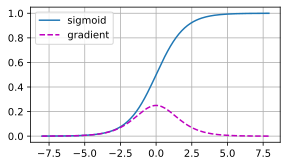

In [15]:
#梯度消失
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [16]:
#梯度爆炸
M = torch.normal(0, 1, size=(4, 4))
print('一個矩陣 \n', M)
for i in range(100):
    M = torch.mm(M, torch.normal(0, 1, size=(4, 4)))

print('乘以100個矩陣後\n', M)

一個矩陣 
 tensor([[ 0.3674, -0.0021, -0.1472, -0.8862],
        [ 0.3597,  1.7795, -0.4261, -0.3480],
        [-1.1396,  0.5397,  0.0587, -0.2471],
        [ 0.6727,  1.3616,  1.2544, -0.3590]])
乘以100個矩陣後
 tensor([[-4.9830e+23, -3.6986e+22, -1.4029e+24,  4.8495e+23],
        [ 1.2262e+24,  9.1009e+22,  3.4519e+24, -1.1933e+24],
        [-2.1662e+23, -1.6078e+22, -6.0984e+23,  2.1081e+23],
        [ 4.4110e+23,  3.2740e+22,  1.2418e+24, -4.2928e+23]])
